# NBA FEATURES SELECTION FOR INVESTMENT DECISION

This analysis is based upon the "nba_dataset.csv". Link below 

https://github.com/MEMAUDATA/memaudata.github.io/blob/main/datasets/nba_dataset.csv

Two questions here : 
1) Identify the best features for investment decision and develop a ML model
2) Create a web app with the previous model. This app will run locally.

NV, Toulouse, octobre,2024

# Install all required librairies from requirements.txt

In [ ]:
pip install -r requirements.txt # type: ignore

# Import librairies

In [340]:
# For preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import joblib as jb 
from matplotlib import pyplot as plt
from scipy import stats as stats
import warnings
import nbconvert

In [341]:
# For modelisation
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif,chi2


# Warnings off

In [342]:
pd.options.mode.chained_assignment = None

 # Load data and do a simple vizualisation step before preprocessing

In [343]:
# Load dataset
df1 = pd.read_csv("datasets/nba_dataset.csv") # warning mac vs windows .// ou .\\

Make a copy of the imported dataframe to work on it in order to avoid issues that need to be adressed by reloading the original csv file that could take a while for big csv file. 

In [344]:
# backup
df = df1.copy()

In [345]:
# Display all columns
pd.set_option("display.max.columns", None)

# shape dataset
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

In [346]:
df.head(3)

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0


# Define independant and dependants variables

This dataset contains 21 columns. The question on investment decision is based upon the column "Target_5YRS" which is, here, our dependant variable (supervided ML).

The remaining columns should be carrefully analyzed for potential data reduction and model optimisation.

Target_5YRS = 0 => No investment
Target_5YRS = 1 => investment


# Start data preprocessing

Duplicates / outliers / Nan values

In [347]:
# Remove duplicates : Keep first player if multiple players
df = df.drop_duplicates(subset='Name', keep="first", inplace=False)
df.shape
# reset index
df = df.reset_index(drop=True)
df.shape

(1294, 21)

1339 - 1294 => 45 duplicates !

Find Nan values or empty values using heatmap

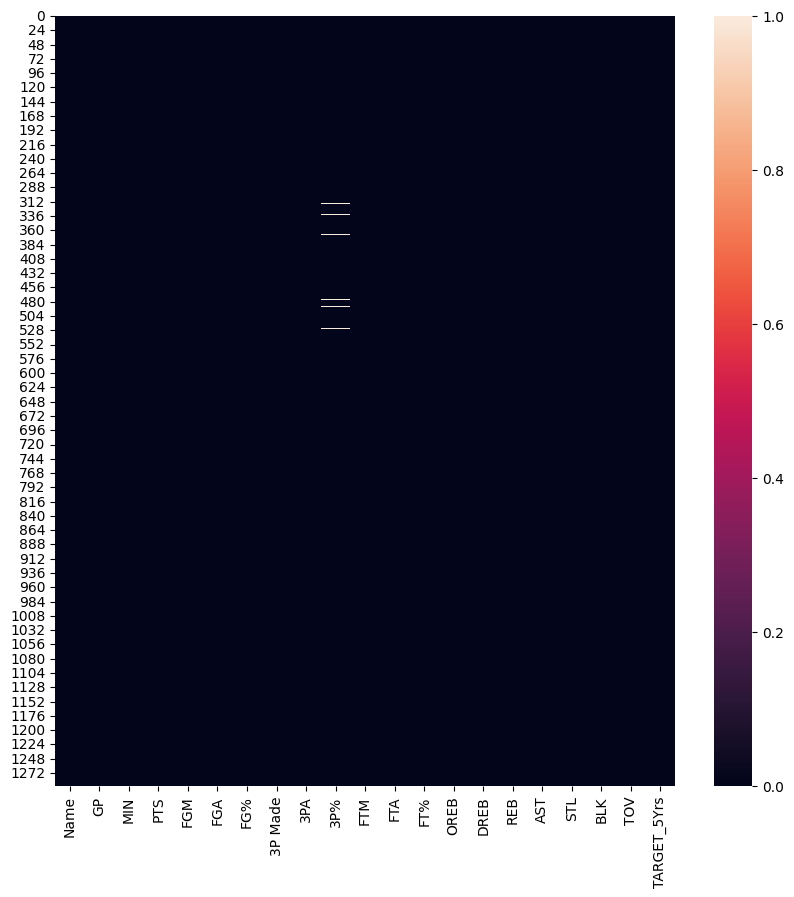

In [348]:
# Plot the entire data with heatmap from seaborn to try to look at valuable column
plt.figure(figsize=(10,10))
sns.heatmap(df.isna()) # 1 = empty
plt.show()

3P% seems to have empty values

Use fillna for empty values

In [349]:
df[["3P%"]] = df[["3P%"]].fillna(np.nan)

Plot data before outliers removal

<Figure size 640x480 with 0 Axes>

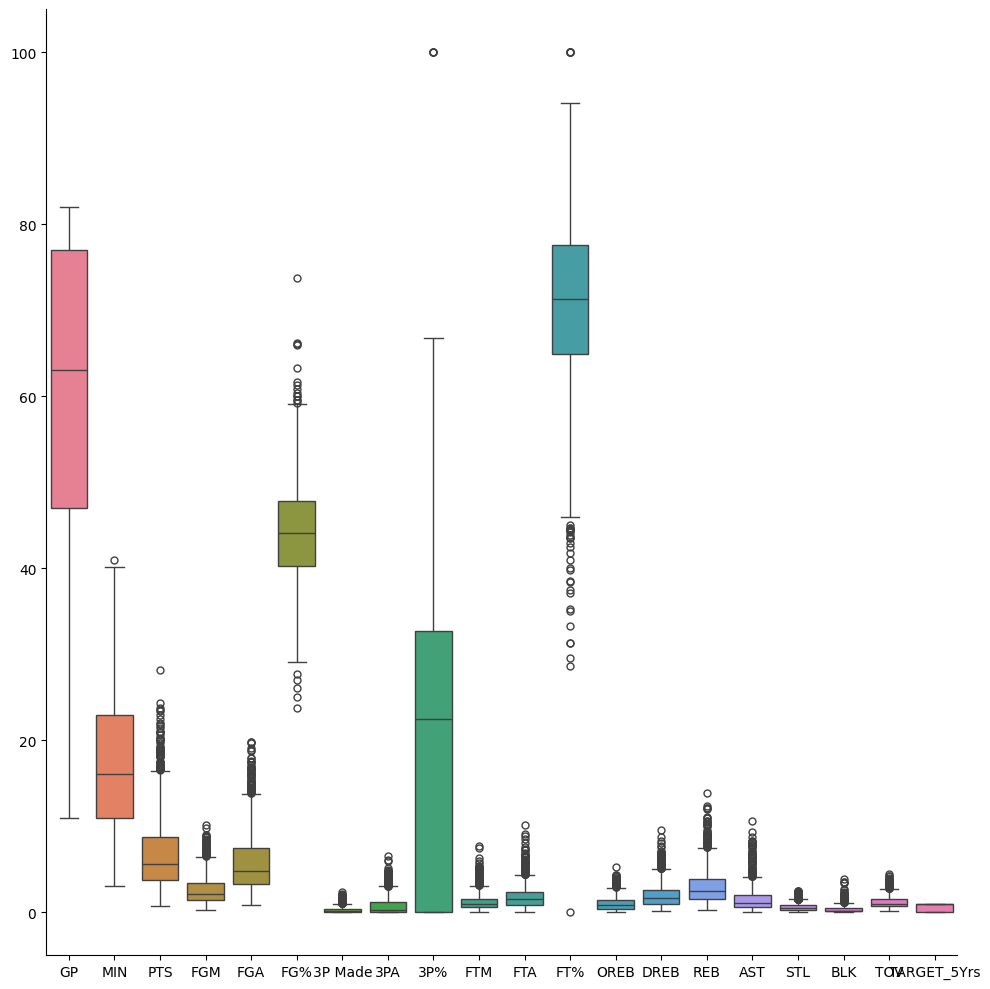

In [350]:
# Group visualization
plt.figure()
sns.catplot(data=df, kind="box",height = 10)
plt.show()

Remove outliers

In [351]:
def remove_outliers_iqr(df, columns, threshold=1.5):
    """ IQR computation to remove outliers """
    df_without_outliers = df.copy()

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        df_without_outliers = df_without_outliers[(df_without_outliers[col] >= lower_bound) & (df_without_outliers[col] <= upper_bound)]

    return df_without_outliers




In [352]:
# Remove target and names before outliers processing
labels  = df.drop(['Name'],axis=1).columns.values
df      = df.drop(['Name'],axis=1)
df      = pd.DataFrame(df)

df_without_outliers = remove_outliers_iqr(df,labels,1.5)
df_without_outliers.reset_index()
print(df_without_outliers.shape)

(948, 20)


Plot data after outliers removal

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

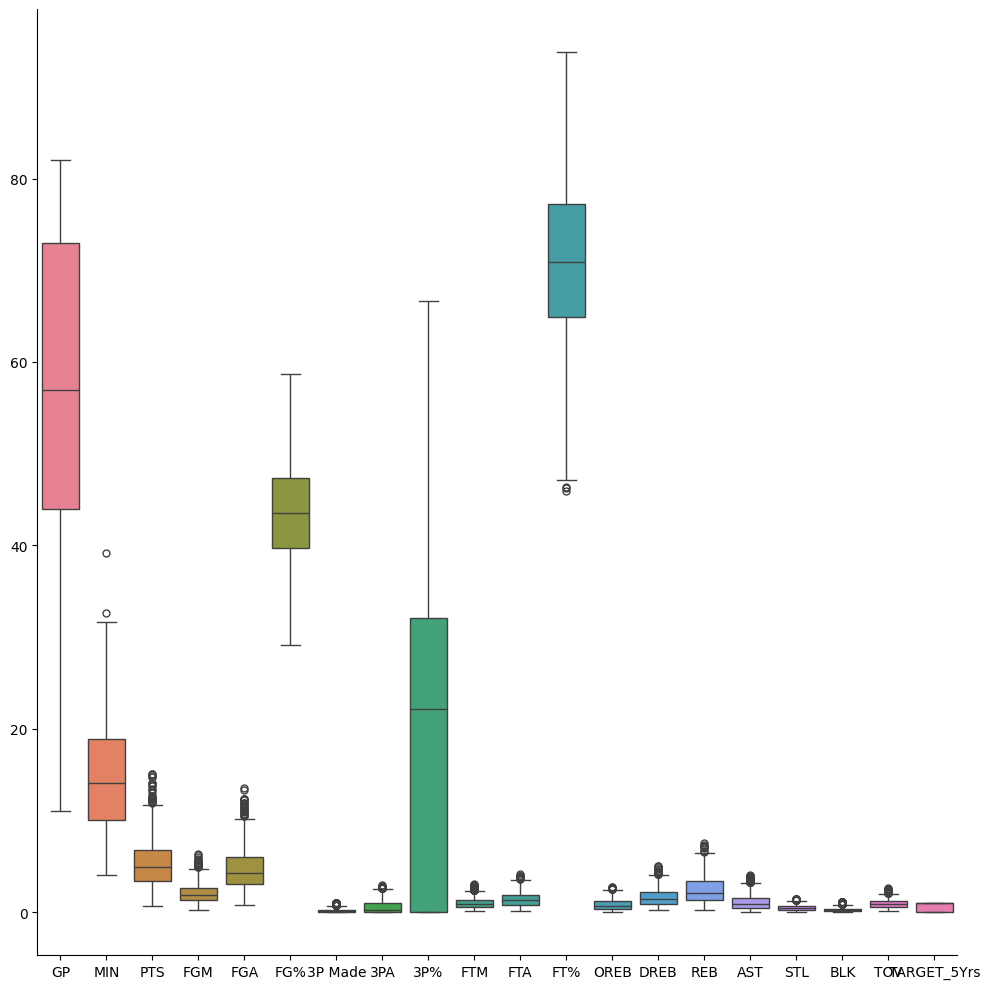

In [353]:
plt.figure()
sns.catplot(data=df_without_outliers, kind="box",height = 10)
plt.show

Save the df_without_outliers dataframe for further preprocessing steps

df_without_outliers will be saved as clean_dataset

Warning : here without outliers means with less outliers !

In [354]:
# final clean dataset
clean_dataset = df_without_outliers 

# save data set with joblib
jb.dump(clean_dataset, "clean_dataset.sav") 


['clean_dataset.sav']

# MODEL PREDICTION

Split train and test set using the clean dataset loaded from folder

In [355]:
# load cleanset to have a nice clean start
loaded_df    = jb.load('clean_dataset.sav')

In [356]:
df = loaded_df.copy()
print(df)

      GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0     36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0  1.6  2.3  69.9   0.7   
1     35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5  2.6  3.4  76.5   0.5   
2     74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4  0.9  1.3  67.0   0.5   
3     58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6  0.9  1.3  68.9   1.0   
4     48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0  1.3  1.9  67.4   1.0   
...   ..   ...  ...  ...  ...   ...      ...  ...   ...  ...  ...   ...   ...   
1289  80  15.8  4.3  1.6  3.6  43.3      0.0  0.2  14.3  1.2  1.5  79.2   0.4   
1290  68  12.6  3.9  1.5  4.1  35.8      0.1  0.7  16.7  0.8  1.0  79.4   0.4   
1291  43  12.1  5.4  2.2  3.9  55.0      0.0  0.0   0.0  1.0  1.6  64.3   1.5   
1292  52  12.0  4.5  1.7  3.8  43.9      0.0  0.2  10.0  1.2  1.8  62.5   0.2   
1293  47  11.7  4.4  1.6  4.4  36.9      0.4  1.3  33.3  0.7  1.0  67.3   0.2   

      DREB  REB  AST  STL  

In [357]:
def prepare_data_for_modelisation(df):

    target  = df['TARGET_5Yrs'].to_numpy()
    labels  = df.drop(['TARGET_5Yrs'],axis=1).columns.values
    df      = df.drop(['TARGET_5Yrs'],axis=1)
    data    = df.to_numpy()

    return  data,target

In [358]:
# For score_classifier function
data, target  = prepare_data_for_modelisation(df)

# MODEL PREDICTION 
## Aim : find the best recall score 

Recall scare => lowest False negative  (on a confusion matrix) 

Define classifiers

In [359]:
SVM             = make_pipeline(MinMaxScaler(),SVC(random_state=0))
KNN             = make_pipeline(MinMaxScaler(),KNeighborsClassifier(5))
Randomforest    = make_pipeline(RandomForestClassifier(random_state=0)) # Normalization not necessarily need it for trees
Adaboost        = make_pipeline(AdaBoostClassifier(algorithm="SAMME",random_state=0))# avoid warning
GNB             = make_pipeline(MinMaxScaler(),GaussianNB())


dict_of_models  = {"SVM" : SVM,
                  "KNN" : KNN,
                  "Randomforest" : Randomforest,
                  "Adaboost" : Adaboost,
                  'GNB':GNB}


Test score_classifier on the entire clean_dataset

In [360]:
def score_classifier(dataset,classifier,labels):

    kf = KFold(n_splits=3,random_state=50,shuffle=True) # bootstraping
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=3
    print('mean recall out of 3 Kflod splits : ' , recall)

   

In [361]:
# Loop over score_classifier
for clf_name, clf in dict_of_models.items():
   
    print('-----' , clf_name ,'-----')
    score_classifier(data, clf, target)

----- SVM -----
mean recall out of 3 Kflod splits :  0.7137111648962137
----- KNN -----
mean recall out of 3 Kflod splits :  0.7018960685932528
----- Randomforest -----
mean recall out of 3 Kflod splits :  0.6802907820989509
----- Adaboost -----
mean recall out of 3 Kflod splits :  0.6692963557558764
----- GNB -----
mean recall out of 3 Kflod splits :  0.5353882779776354


Based on score_classifier function => choose best algorithm that maximizes recall score

Split data

In [362]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

Prepare for future modelisation

In [363]:
X_train, Y_train    = prepare_data_for_modelisation(trainset)
X_test, Y_test      = prepare_data_for_modelisation(testset)
print(X_train.shape)
print(X_test.shape)

(758, 19)
(190, 19)


Normalize X_train and X_test data

In [364]:
scaler          = MinMaxScaler() # to save it later
X_train         = scaler.fit_transform(X_train)
X_test          = scaler.transform(X_test) 

Model optimization / Hyperparameters fine tuning / features selection

In [365]:
model_selected      = SVC()
model_selected.fit(X_train, Y_train)
Y_pred              = model_selected.predict(X_test)
recall              = recall_score(Y_test, Y_pred)
print(recall)

0.7474747474747475


Hyperparameters fine tuning

In [366]:
model_to_optimize = make_pipeline(SVC()) 
hyper_parameters = {'svc__gamma':['auto'],
                    'svc__C' : [0.1,1,10,20,100] , 
                    'svc__kernel':['rbf','linear','sigmoid','poly'],
                    'svc__degree':[2,3,4]} 

grid_search = GridSearchCV(model_to_optimize, hyper_parameters,scoring='recall',cv=3)
grid_search.fit(X_train,Y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best Score: 1.0


Model optimized based upon Hyperparameters

In [367]:
model_optimized      = grid_search.best_estimator_
model_optimized.fit(X_train, Y_train)
Y_pred              = model_optimized.predict(X_test)
recall              = recall_score(Y_test, Y_pred)
print(recall)

1.0


Overfitting ?? I don't think so. Let's see now if we can reduce our dataset 

# Based upon the recall score, do we need all features ?

Use : SelectKBest for Features selection

In [368]:
features        =  df.drop(["TARGET_5Yrs"],axis=1)
bestfeatures    = SelectKBest(score_func=f_classif) # choose from figure
data_trim       = bestfeatures.fit(X_train, Y_train)
filter          = bestfeatures.get_support()


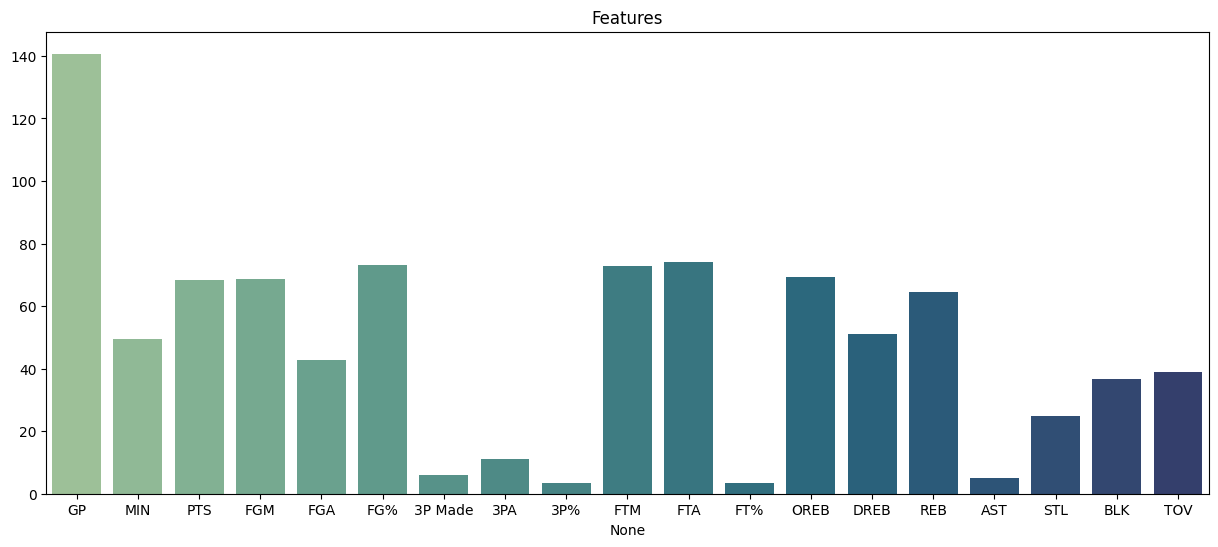

In [369]:
plt.figure(figsize=(15, 6))
sns.barplot(x=features.columns,y=bestfeatures.scores_,hue=features.columns,palette="crest",legend=False)
plt.title("Features")
plt.show()


# Select k for the SelectKBest function of scikit learn

Reduce data and test model again

In [380]:
for i in range(19):
    # features selection
    bestfeatures        = SelectKBest(score_func=f_classif,k=i+1) # choose from figure
    data_trim           = bestfeatures.fit_transform(X_train, Y_train)
    filter              = bestfeatures.get_support()
    selected_features   = features.columns[filter]

    # Data reduction
    reduce_dataset = df[selected_features]
    reduce_dataset["TARGET_5Yrs"] = df["TARGET_5Yrs"]

    trainset_reduce_data, testset_reduce_data = train_test_split(reduce_dataset, test_size=0.2, random_state=0)
    # rd for reduced_daraset
    X_train_rd, Y_train_rd    = prepare_data_for_modelisation(trainset_reduce_data)
    X_test_rd, Y_test_rd      = prepare_data_for_modelisation(testset_reduce_data)

    # Data normalization
    scaler              = MinMaxScaler() # to save it later
    X_train_rd          = scaler.fit_transform(X_train_rd)
    X_test_rd           = scaler.transform(X_test_rd) 

    # Test model again
    model_optimized.fit(X_train_rd, Y_train_rd)
    Y_pred              = model_optimized.predict(X_test_rd)
    recall              = recall_score(Y_test_rd, Y_pred)

    print(f"{i+1} feature(s) => recall {recall} => {list(selected_features)} ")

    

1 feature(s) => recall 0.7433628318584071 => ['GP'] 
2 feature(s) => recall 0.7522123893805309 => ['GP', 'FTA'] 
3 feature(s) => recall 0.8053097345132744 => ['GP', 'FG%', 'FTA'] 
4 feature(s) => recall 0.831858407079646 => ['GP', 'FG%', 'FTM', 'FTA'] 
5 feature(s) => recall 0.7876106194690266 => ['GP', 'FG%', 'FTM', 'FTA', 'OREB'] 
6 feature(s) => recall 0.7876106194690266 => ['GP', 'FGM', 'FG%', 'FTM', 'FTA', 'OREB'] 
7 feature(s) => recall 0.7964601769911505 => ['GP', 'PTS', 'FGM', 'FG%', 'FTM', 'FTA', 'OREB'] 
8 feature(s) => recall 0.7876106194690266 => ['GP', 'PTS', 'FGM', 'FG%', 'FTM', 'FTA', 'OREB', 'REB'] 
9 feature(s) => recall 0.7964601769911505 => ['GP', 'PTS', 'FGM', 'FG%', 'FTM', 'FTA', 'OREB', 'DREB', 'REB'] 
10 feature(s) => recall 0.8141592920353983 => ['GP', 'MIN', 'PTS', 'FGM', 'FG%', 'FTM', 'FTA', 'OREB', 'DREB', 'REB'] 
11 feature(s) => recall 0.8230088495575221 => ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', 'FTM', 'FTA', 'OREB', 'DREB', 'REB'] 
12 feature(s) => reca

With 4 features only, the recall score is similar to somewhat between 12 or 13 features 

Final model optimisation

In [381]:
nb_features = 4

# features selection
bestfeatures        = SelectKBest(score_func=f_classif,k=nb_features) # choose from figure
data_trim           = bestfeatures.fit_transform(X_train, Y_train)
filter              = bestfeatures.get_support()
selected_features   = features.columns[filter]

# Data reduction
reduce_dataset = df[selected_features]
reduce_dataset["TARGET_5Yrs"] = df["TARGET_5Yrs"]


print(reduce_dataset)

trainset_reduce_data, testset_reduce_data = train_test_split(reduce_dataset, test_size=0.2, random_state=0)
# rd for reduced_daraset
X_train_rd, Y_train_rd    = prepare_data_for_modelisation(trainset_reduce_data)
X_test_rd, Y_test_rd      = prepare_data_for_modelisation(testset_reduce_data)

# Data normalization
scaler              = MinMaxScaler() # to save it later
X_train_rd          = scaler.fit_transform(X_train_rd)
X_test_rd           = scaler.transform(X_test_rd) 

# Test model again
model_optimized.fit(X_train_rd, Y_train_rd)
Y_pred              = model_optimized.predict(X_test_rd)
recall              = recall_score(Y_test_rd, Y_pred)

print(f"{nb_features} features => recall {recall}")

      GP   FG%  FTM  FTA  TARGET_5Yrs
0     36  34.7  1.6  2.3          0.0
1     35  29.6  2.6  3.4          0.0
2     74  42.2  0.9  1.3          0.0
3     58  42.6  0.9  1.3          1.0
4     48  52.4  1.3  1.9          1.0
...   ..   ...  ...  ...          ...
1289  80  43.3  1.2  1.5          0.0
1290  68  35.8  0.8  1.0          1.0
1291  43  55.0  1.0  1.6          0.0
1292  52  43.9  1.2  1.8          1.0
1293  47  36.9  0.7  1.0          1.0

[948 rows x 5 columns]
4 features => recall 0.831858407079646


# Save final model

In [372]:
# %% save model with joblib 
jb.dump(scaler, "scaler.sav") 
jb.dump(model_optimized,'nba_model_optimzed.sav')

['nba_model_optimzed.sav']

Test some predictions

In [382]:
X           = [[0 ,42.6 , 0.9 , 1.3 ]]
X_scaled    = scaler.transform(X)
Y           = model_optimized.predict(X_scaled)
print(Y)

[0.]


Conclusion : The recall score with a reduced dataset of 4 features (from originally 19) is about 0,83. 

The final criterion decision would have to be discussed in order to understand the acceptable limits.